In [11]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


# Sprint 0 :Perform EDA with basic plots

In [4]:
import pandas as pd

df = pd.read_csv("spam.csv", encoding='latin-1')

if 'v1' in df.columns and 'v2' in df.columns:
    df = df[['v1', 'v2']]
    df.columns = ['label', 'message']
elif 'Category' in df.columns and 'Message' in df.columns:
    df = df[['Category', 'Message']]
    df.columns = ['label', 'message']
else:
    df = df[['label', 'message']]

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

print(df.head())
print(df.info())
print(df['label'].value_counts())


  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
label
ham     4825
spam     747
Name: count, dtype: int64


In [6]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['message'] = df['message'].apply(clean_text)


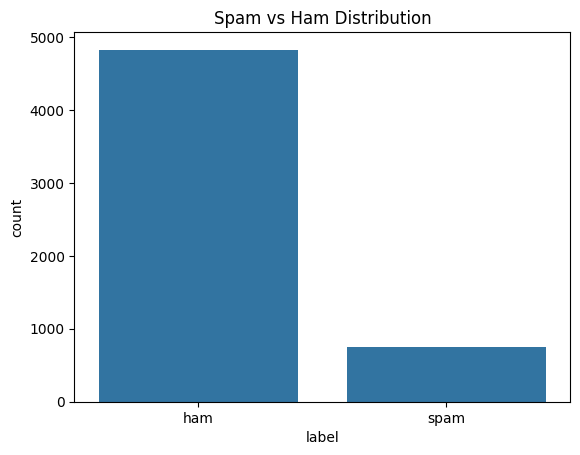

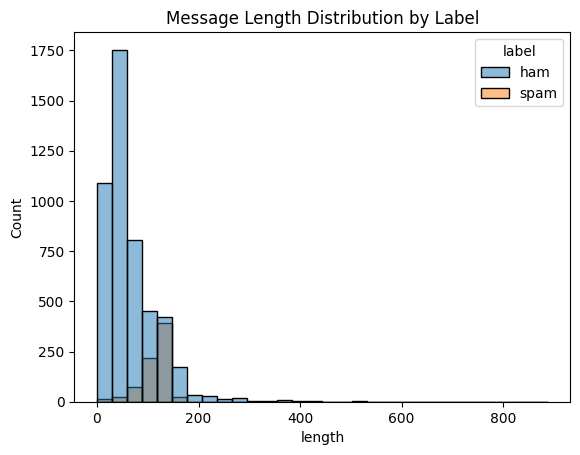

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of labels
sns.countplot(x='label', data=df)
plt.title("Spam vs Ham Distribution")
plt.show()

# Message length
df['length'] = df['message'].apply(len)
sns.histplot(data=df, x='length', hue='label', bins=30)
plt.title("Message Length Distribution by Label")
plt.show()


# Sprint 1 : Preprocessing

In [16]:
from sklearn.model_selection import train_test_split

X = df['message']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


# Sprint 2 : Model Development 

In [21]:
spam_keywords = [
    "win", "prize", "free", "offer", "deal", "loan", "credit",
    "cash", "buy 1 get 1", "limited time", "apply now", "click here", "reward"
]


In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)


,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [27]:

# SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_vec, y_train)


,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [29]:

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vec, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [31]:

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_vec, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [33]:
models = {"Naive Bayes": nb_model, "SVM": svm_model, 
          "Random Forest": rf_model, "Logistic Regression": lr_model}

for name, m in models.items():
    y_pred = m.predict(X_test_vec)
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred, labels=['ham','spam']))


--- Naive Bayes ---
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       1.00      0.75      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115

--- SVM ---
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       1.00      0.93      0.96       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.98      1115
weighted avg       0.99      0.99      0.99      1115

--- Random Forest ---
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       966
        spam       1.00      0.81      0.90       149

    accuracy                           0.97      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0

### Observation:

SVM has the highest spam recall and highest overall accuracy (~0.99)

Pick SVM as the final ML model

In [36]:
best_model = svm_model

def predict_hybrid(msg):
    msg_lower = msg.lower()
    for keyword in spam_keywords:
        if keyword in msg_lower:
            return "spam"
    msg_vec = vectorizer.transform([msg])
    return best_model.predict(msg_vec)[0]


# Sprint 3 : NLP Architecture

In [40]:
vectorizer_ngram = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
X_train_vec_ngram = vectorizer_ngram.fit_transform(X_train)
X_test_vec_ngram = vectorizer_ngram.transform(X_test)

# Train SVM with n-grams
svm_model_ngram = SVC(kernel='linear', probability=True)
svm_model_ngram.fit(X_train_vec_ngram, y_train)


,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [42]:
best_model = svm_model_ngram
vectorizer = vectorizer_ngram

def predict_hybrid(msg):
    for keyword in spam_keywords:
        if keyword in msg.lower():
            return "spam"
    msg_vec = vectorizer.transform([msg])
    return best_model.predict(msg_vec)[0]


In [44]:
test_messages = [
    "Win a free iPhone now!",
    "Limited-time offer just for you!",
    "Hey, are we meeting tomorrow?",
    "Don't forget the meeting at 3 PM."
]

for msg in test_messages:
    print(msg, "->", predict_hybrid(msg))


Win a free iPhone now! -> spam
Limited-time offer just for you! -> spam
Hey, are we meeting tomorrow? -> ham
Don't forget the meeting at 3 PM. -> ham


# Sprint 4 : Model Deployment

In [49]:
import pickle

pickle.dump(best_model, open("spam_model.pkl", "wb"))
pickle.dump(vectorizer, open("vectorizer.pkl", "wb"))


In [51]:
loaded_model = pickle.load(open("spam_model.pkl", "rb"))
loaded_vectorizer = pickle.load(open("vectorizer.pkl", "rb"))

def predict_deploy(msg):
    for keyword in spam_keywords:
        if keyword in msg.lower():
            return "spam"
    msg_vec = loaded_vectorizer.transform([msg])
    return loaded_model.predict(msg_vec)[0]


In [53]:
import pickle

# Load model and vectorizer
loaded_model = pickle.load(open("spam_model.pkl", "rb"))
loaded_vectorizer = pickle.load(open("vectorizer.pkl", "rb"))

# Define spam keywords
spam_keywords = [
    "win", "prize", "free", "offer", "deal", "loan", "credit",
    "cash", "buy 1 get 1", "limited time", "apply now", "click here", "reward"
]

# Hybrid detector function
def predict_hybrid(msg):
    """
    Returns 'spam' or 'ham' using keyword check + SVM model
    """
    for keyword in spam_keywords:
        if keyword in msg.lower():
            return "spam"
    msg_vec = loaded_vectorizer.transform([msg])
    return loaded_model.predict(msg_vec)[0]


In [55]:
test_messages = [
    "Win a brand new car! Click here to claim your prize.",
    "Get cheap loans approved instantly. No credit check.",
    "Limited-time offer! Buy 1 get 1 free.",
    "Hey, are we meeting tomorrow?",
    "Don't forget the meeting at 3 PM.",
    "Your Amazon order has been shipped and will arrive tomorrow.",
    "Congratulations! You’ve won a free iPhone. Click the link to claim now.",
    "Can you call me when you're free?",
    "Hot singles in your area waiting to chat!",
    "Happy birthday! Wish you a great day!"
]

# Predict and print
for msg in test_messages:
    print(f"Message: {msg}\nPredicted: {predict_hybrid(msg)}\n")


Message: Win a brand new car! Click here to claim your prize.
Predicted: spam

Message: Get cheap loans approved instantly. No credit check.
Predicted: spam

Message: Limited-time offer! Buy 1 get 1 free.
Predicted: spam

Message: Hey, are we meeting tomorrow?
Predicted: ham

Message: Don't forget the meeting at 3 PM.
Predicted: ham

Message: Your Amazon order has been shipped and will arrive tomorrow.
Predicted: ham

Message: Congratulations! You’ve won a free iPhone. Click the link to claim now.
Predicted: spam

Message: Can you call me when you're free?
Predicted: spam

Message: Hot singles in your area waiting to chat!
Predicted: spam

Message: Happy birthday! Wish you a great day!
Predicted: ham

